# Análisis Exploratorio: San Francisco Bay Bike Rental

https://www.kaggle.com/benhamner/sf-bay-area-bike-share

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
%matplotlib inline

In [2]:
trip_meta = pd.read_csv('data/trip.csv')
weather_meta = pd.read_csv('data/weather.csv')

In [3]:
pd.options.mode.chained_assignment = None

### Convierto las fechas a datetime

In [4]:
trip_meta['start_date'] = pd.to_datetime(trip_meta['start_date'])

In [5]:
trip_meta['end_date'] = pd.to_datetime(trip_meta['end_date'])

In [6]:
import datetime
from datetime import date,time

In [7]:
#Saco los horarios de las fechas para analizar primero los viajes que son realizados durante el mismo dia
trip_meta['start_date2'] = trip_meta.start_date.apply(lambda x: datetime.datetime(x.year, x.month, x.day,0,0))
trip_meta['end_date2'] = trip_meta.end_date.apply(lambda x: datetime.datetime(x.year, x.month, x.day,0,0))

In [8]:
#Paso las duraciones de los viajes a minutos
trip_meta.duration = trip_meta.duration.apply(lambda x: x/60.0)

In [9]:
trip_meta.rename(columns={'duration':'duration(min)'},inplace=True)

In [10]:
trip_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669959 entries, 0 to 669958
Data columns (total 13 columns):
id                    669959 non-null int64
duration(min)         669959 non-null float64
start_date            669959 non-null datetime64[ns]
start_station_name    669959 non-null object
start_station_id      669959 non-null int64
end_date              669959 non-null datetime64[ns]
end_station_name      669959 non-null object
end_station_id        669959 non-null int64
bike_id               669959 non-null int64
subscription_type     669959 non-null object
zip_code              663340 non-null object
start_date2           669959 non-null datetime64[ns]
end_date2             669959 non-null datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(4), object(4)
memory usage: 66.4+ MB


In [11]:
same_day = trip_meta.loc[trip_meta.start_date2 == trip_meta.end_date2,['id','duration(min)','start_date2','end_date2','start_station_name','start_station_id','end_station_name','end_station_id']]

In [12]:
print len(trip_meta) - len(same_day)

2099


## Entendemos que como son 2099 los viajes que empiezan un dia y terminan en otro (insignificativo frente a la enorme cantidad de registros) ante la posibilidad de que haya viajes de mas de un dia, o muy largos preferimos filtrarlos.

In [13]:
same_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 667860 entries, 0 to 669958
Data columns (total 8 columns):
id                    667860 non-null int64
duration(min)         667860 non-null float64
start_date2           667860 non-null datetime64[ns]
end_date2             667860 non-null datetime64[ns]
start_station_name    667860 non-null object
start_station_id      667860 non-null int64
end_station_name      667860 non-null object
end_station_id        667860 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 45.9+ MB


In [14]:
same_day.describe()

,id,duration(min),start_station_id,end_station_id
count,667860.000000,667860.000000,667860.000000,667860.00000
mean,460563.297664,14.936870,57.877699,57.85896
std,264565.577399,36.510578,17.088461,17.17720
min,4069.000000,1.000000,2.000000,2.00000
25%,231317.750000,5.733333,50.000000,50.00000
50%,459550.000000,8.600000,62.000000,62.00000
75%,692844.250000,12.550000,70.000000,70.00000
max,913460.000000,1390.150000,84.000000,84.00000


### Filtro los viajes que duran menos de 5 minutos

In [15]:
trips_longer = same_day.loc[same_day['duration(min)'] > 5,:]

In [16]:
trips_longer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542405 entries, 100 to 669958
Data columns (total 8 columns):
id                    542405 non-null int64
duration(min)         542405 non-null float64
start_date2           542405 non-null datetime64[ns]
end_date2             542405 non-null datetime64[ns]
start_station_name    542405 non-null object
start_station_id      542405 non-null int64
end_station_name      542405 non-null object
end_station_id        542405 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 37.2+ MB


### Son 125455 los viajes que duran menos de 5 min

In [17]:
print len(same_day) - len(trips_longer)

125455


In [18]:
# Convierto a datetime la fecha en el DF weather
weather_meta['date'] = pd.to_datetime(weather_meta['date'])

# Viajes segun las condiciones climaticas

### Analizo la cantidad de viajes segun la temperatura

In [19]:
temperatures = weather_meta[['date','max_temperature_f','mean_temperature_f','min_temperature_f']]

In [20]:
# Paso la temperatura a Celsius
temperatures.max_temperature_f = temperatures.max_temperature_f.apply(lambda x: (x-32) / 1.8)
temperatures.mean_temperature_f = temperatures.mean_temperature_f.apply(lambda x: (x-32) / 1.8)
temperatures.min_temperature_f = temperatures.min_temperature_f.apply(lambda x: (x-32) / 1.8)

In [21]:
temperatures.rename(
    columns={'max_temperature_f':'max_temperature_c','mean_temperature_f':'mean_temperature_c','min_temperature_f':'min_temperature_c'},inplace=True)

In [22]:
temperatures_avg = temperatures.groupby('date').mean()
temperatures_avg = pd.DataFrame(temperatures_avg.to_records())

In [23]:
final = trips_longer[['id', 'duration(min)', 'start_date2', 'start_station_name','end_station_name']]
final.rename(columns={'start_date2':'date'},inplace=True)

In [24]:
date_duration = final.loc[:,['duration(min)','date']].groupby('date').agg([np.size])
date_duration = pd.DataFrame(date_duration.to_records())
date_duration.columns=['date','# trips']

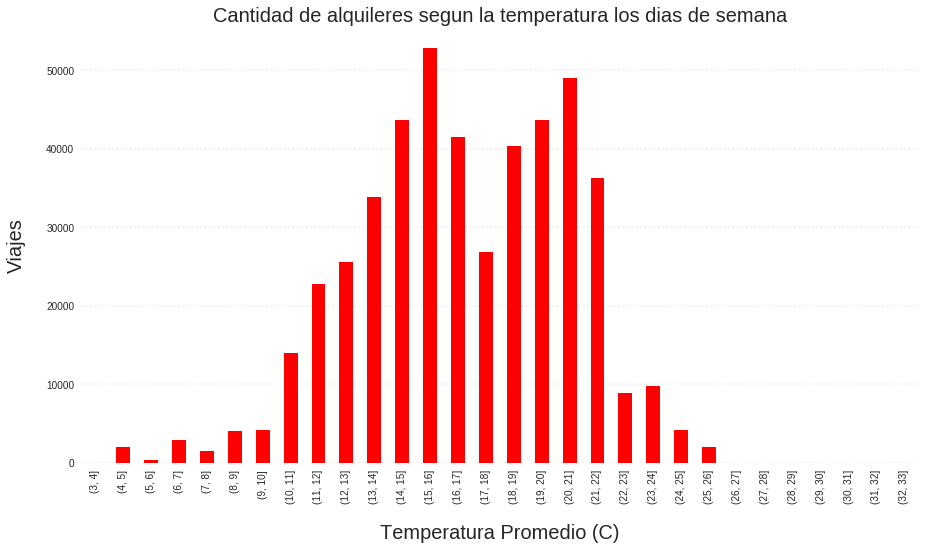

In [25]:
duration_temperature = pd.merge(date_duration,temperatures_avg,how='inner',on='date')
duration_temperature['weekday'] = duration_temperature.date.apply(lambda x: x.weekday())
duration_temperature_weekdays = duration_temperature\
                        .loc[(duration_temperature.weekday != 5) & (duration_temperature.weekday != 6),:]

duration_temperature_weekdays = duration_temperature_weekdays\
                        [['# trips','date','max_temperature_c','mean_temperature_c','min_temperature_c']]
    
trips_temperature = duration_temperature_weekdays.\
                groupby(pd.cut(duration_temperature_weekdays['mean_temperature_c'], np.arange(3,34))).sum()

f = plt.figure()
ax = trips_temperature['# trips'].plot.bar(figsize=(15,8),colormap='autumn',layout=('# trips','Mean Temperature (C)'), ax=f.gca())
ax.set_ylabel('Viajes',size=20.0,labelpad=20.0);
ax.set_xlabel('Temperatura Promedio (C)',size=20.0,labelpad=20.0);
ax.set_facecolor('white')
ax.grid(color='k',axis='y' ,linestyle='dotted', linewidth=0.1)
ax.set_title('Cantidad de alquileres segun la temperatura los dias de semana',size=20.0)
plt.show()

# --------------------------------------------------------------------------------------------------

### Alquiler de bicicletas segun la lluvia, los dias de semana

In [26]:
precipitation = weather_meta[['date','precipitation_inches']]

In [27]:
precipitation.columns = ['date','inches']

In [28]:
precipitation = precipitation.loc[precipitation.inches != 'T',:]
precipitation.inches = pd.to_numeric(precipitation.inches)

In [29]:
precipitation = precipitation.groupby('date').mean()
precipitation = pd.DataFrame(precipitation.to_records())

In [30]:
precipitation_trips = pd.merge(date_duration,precipitation,how='inner',on='date')

In [31]:
precipitation_trips = precipitation_trips[['# trips','date','inches']]

In [32]:
precipitation_trips['weekday'] = precipitation_trips.date.apply(lambda x: x.weekday())
precipitation_trips = precipitation_trips.loc[precipitation_trips.weekday < 5,:]

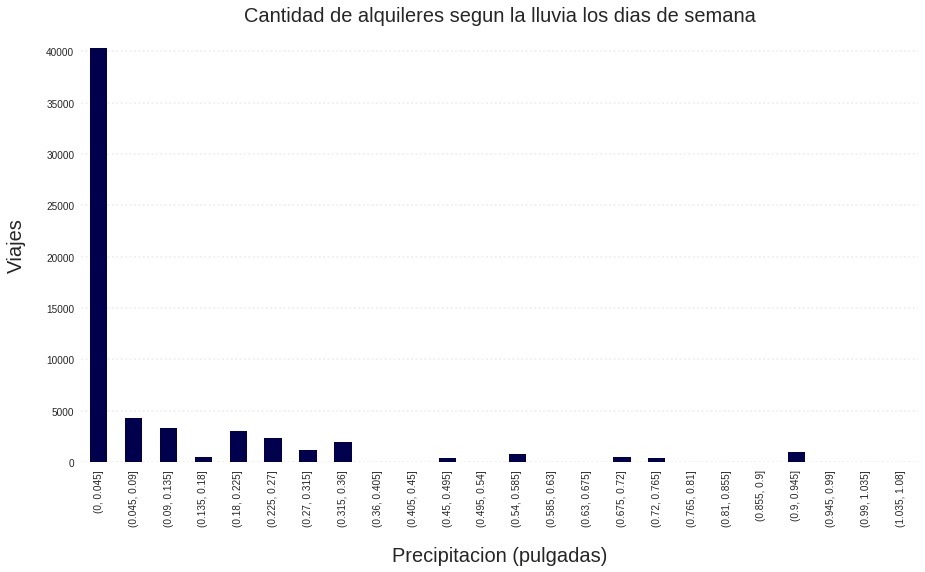

In [33]:
precipitation_trips_plot = precipitation_trips.\
                groupby(pd.cut(precipitation_trips['inches'], np.arange(0, 1.1, 0.045))).sum()

f = plt.figure()
ax = precipitation_trips_plot['# trips'].plot.bar(figsize=(15,8),colormap='seismic',ax=f.gca())
ax.set_ylabel('Viajes',size=20.0,labelpad=20.0);
ax.set_xlabel('Precipitacion (pulgadas)',size=20.0,labelpad=20.0);
ax.set_facecolor('white')
ax.grid(color='k',axis='y' ,linestyle='dotted', linewidth=0.1)
ax.set_title('Cantidad de alquileres segun la lluvia los dias de semana',size=20.0)
plt.show()

# ------------------------------------------------------------------------------------------------------

## Vajes segun la nubosidad


In [34]:
cloudy = weather_meta[['date','cloud_cover']].groupby('date').mean()
cloudy_avg = pd.DataFrame(cloudy.to_records())

In [35]:
cloudy_stats = pd.merge(final,cloudy_avg,how='inner',on='date')

## ¿Cual es el porcentaje de viajes en días de nubosidad elevada?

In [36]:
total_cloudy = cloudy_stats.count()
travels_cloudy = cloudy_stats.loc[cloudy_stats.cloud_cover > 4].count() / cloudy_stats.count()
print travels_cloudy['id'] * 100

22.889169532


## Los días de nubosidad elevada, se utiliza en menor cantidad el servicio de rental.

### Aclaración: se consideró un día de nubosidad elevada cuando en esta escala que va de 0 a 8, es mayor a 4 el valor.

## ¿Influye la nubosidad en el largo de los viajes?

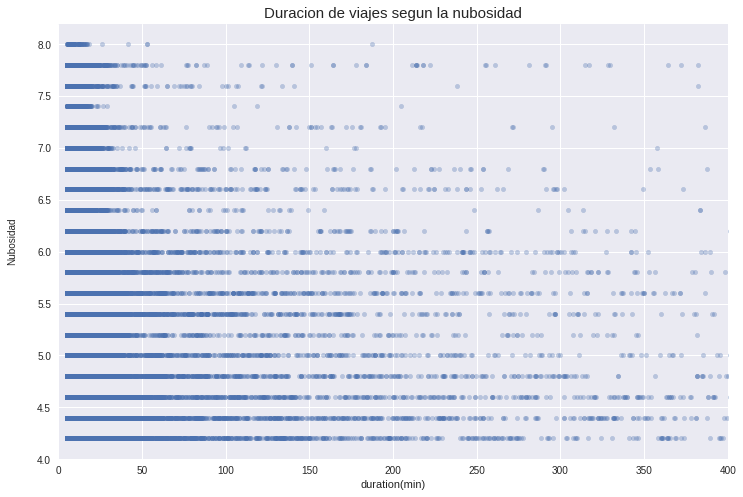

In [37]:
travels_cloudy = cloudy_stats.loc[cloudy_stats.cloud_cover > 4]
fig = plt.figure()
ax = plt.subplot(111)
travels_cloudy.plot.scatter('duration(min)','cloud_cover',alpha=0.32,figsize=(12,8),ax=ax);
ax.set_ylabel('Nubosidad',size=10.0,labelpad=20.0)
ax.set_xlim(0,400);
ax.set_title('Duracion de viajes segun la nubosidad', fontsize=15)

## En los días de nubosidad elevada, se ve como a partir que aumenta la nubosidad, disminuye la cantidad de viajes largos, por lo que sí influye.

## Cuánto más nublado se presente el día más cortos serán los viajes en ese día.

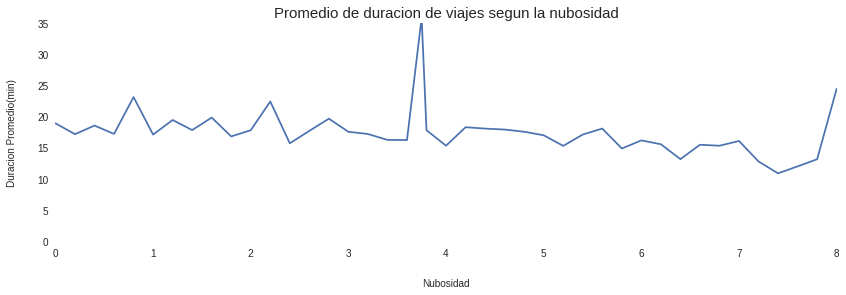

In [38]:
# Cloud cover vs duration
ax = cloudy_stats.groupby('cloud_cover').mean()['duration(min)'].plot(figsize=(14,4));
ax.set_facecolor('white')
ax.set_ylabel('Duracion Promedio(min)',size=10.0,labelpad=20.0)
ax.set_xlabel('Nubosidad',size=10.0,labelpad=20.0)
ax.set_ylim(0,35)
ax.set_title('Promedio de duracion de viajes segun la nubosidad', fontsize=15)

# Viajes segun el anio

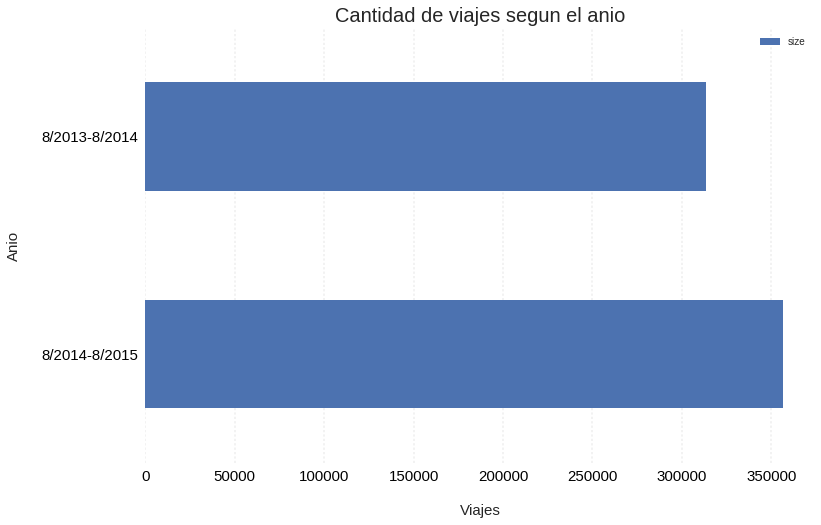

In [39]:
mitad = datetime.datetime(2014,8,29)
trips_year = trip_meta['duration(min)'].groupby(trip_meta.start_date < mitad).agg([np.size])
f = plt.figure()
ax = trips_year.plot.barh(figsize=(12,8))
ax.set_xlabel('Viajes',size=15.0,labelpad=20.0)
ax.set_ylabel('Anio',size=15.0,labelpad=20.0)
ax.tick_params('both', colors='k',labelsize=15.0)
ax.grid(color='k',axis='x' ,linestyle='dotted', linewidth=0.1)
ax.set_yticklabels(['8/2014-8/2015','8/2013-8/2014'])
ax.set_facecolor('white')
ax.set_title('Cantidad de viajes segun el anio',size=20.0)
plt.show()

# Alquileres de bicicleta segun el mes del anio

In [40]:
trip_meta['month'] = trip_meta.start_date.apply(lambda x: x.month)

In [41]:
import matplotlib.patches as mpatches

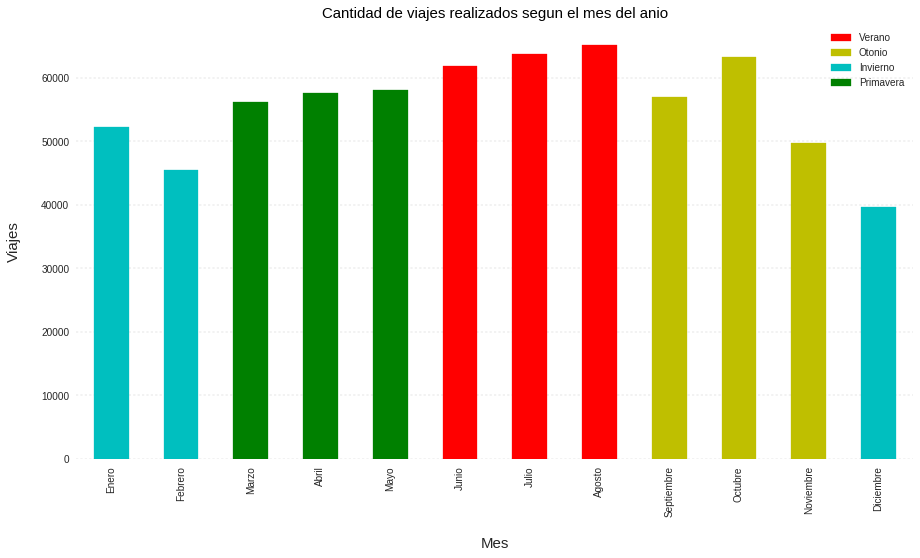

In [42]:
f = plt.figure()
ax = trip_meta.groupby('month').size().plot(kind='bar',figsize=(15,8))
ax.set_ylabel('Viajes',size=15.0,labelpad=20.0)
ax.set_xlabel('Mes',size=15.0,labelpad=20.0)
ax.set_facecolor('white')
ax.set_title('Cantidad de viajes realizados segun el mes del anio', color='black',size=15.0)
red_patch = mpatches.Patch(color='r', label='Verano');yellow_patch = mpatches.Patch(color='y', label='Otonio')
cyan_patch = mpatches.Patch(color='c', label='Invierno');green_patch = mpatches.Patch(color='g', label='Primavera');
plt.legend(handles=[red_patch,yellow_patch,cyan_patch,green_patch])
ax.grid(color='k', linestyle='dotted',axis='y',linewidth=0.1)
ax.get_children()[0].set_color('c');ax.get_children()[1].set_color('c');ax.get_children()[2].set_color('g')
ax.get_children()[3].set_color('g');ax.get_children()[4].set_color('g');ax.get_children()[5].set_color('r')
ax.get_children()[6].set_color('r');ax.get_children()[7].set_color('r');ax.get_children()[8].set_color('y')
ax.get_children()[9].set_color('y');ax.get_children()[10].set_color('y');ax.get_children()[11].set_color('c')
ax.set_xticklabels(['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre'])
plt.show()

# Alquiler de bicicletas por hora

In [43]:
trip_meta['hour'] = trip_meta.start_date.apply(lambda x: x.hour)

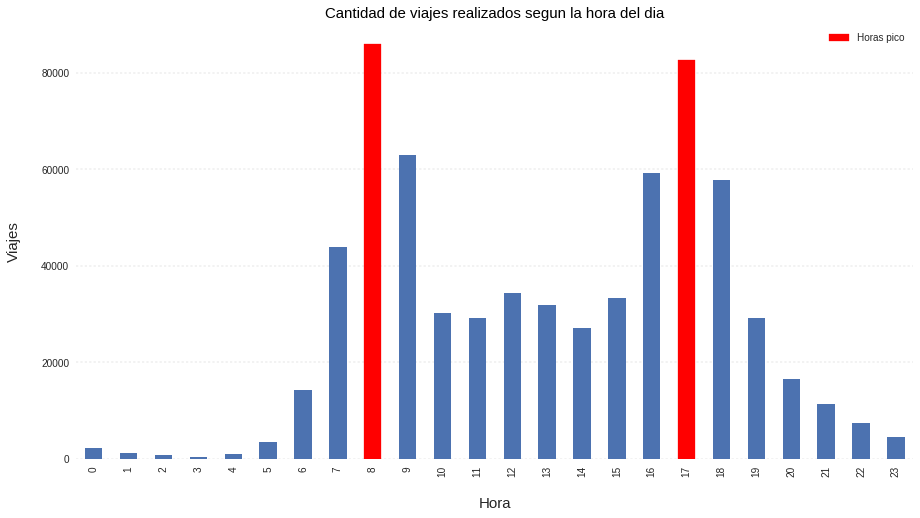

In [44]:
f = plt.figure()
ax = trip_meta.groupby('hour').size().plot(kind='bar',figsize=(15,8))
ax.get_children()[8].set_color('r');ax.get_children()[17].set_color('r')
ax.grid(color='k', linestyle='dotted',axis='y' ,linewidth=0.1)
ax.set_ylabel('Viajes',size=15.0,labelpad=20.0)
ax.set_xlabel('Hora',size=15.0,labelpad=20.0)
ax.set_title('Cantidad de viajes realizados segun la hora del dia', color='black',size=15.0)
ax.set_facecolor('white')
red_patch = mpatches.Patch(color='r', label='Horas pico')
plt.legend(handles=[red_patch])
plt.show()

# ¿Cuál es la franja horaria mas popular los fines de semana?

In [45]:
weekend_hour = trip_meta[['start_date']]
weekend_hour['hour'] = weekend_hour.start_date.apply(lambda x: x.hour)
weekend_hour['weekday'] = weekend_hour.start_date.apply(lambda x: x.weekday())
weekend_hour = weekend_hour.loc[weekend_hour.weekday>4,:]

In [46]:
def ax_paint_area(min,max):
    for x in range(min,max):
        ax.get_children()[x].set_color('r');

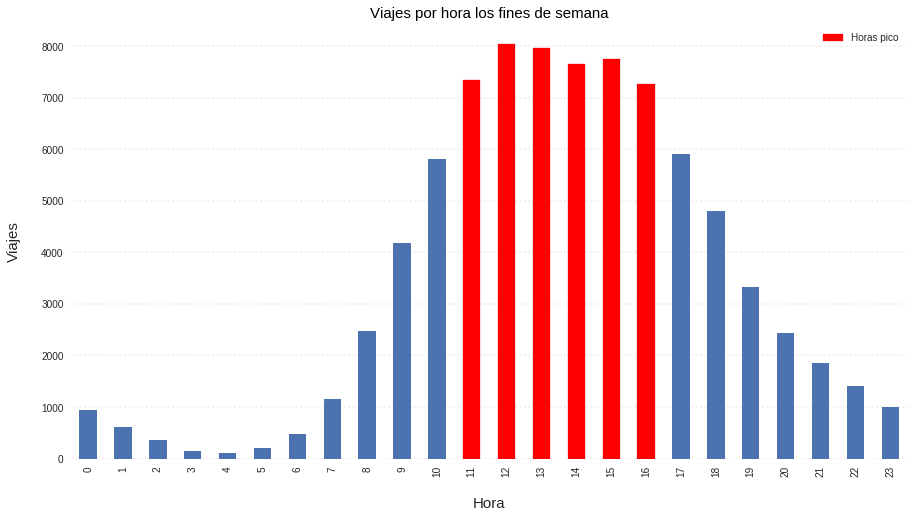

In [47]:
MIN_RUSH=11
MAX_RUSH=17

f = plt.figure()
plt.title('Viajes por hora los fines de semana', color='black', fontsize = 15)
ax = weekend_hour.groupby('hour').size().plot(kind='bar',figsize=(15,8))
ax.grid(color='k', linestyle='dotted',axis='y' ,linewidth=0.1)
ax_paint_area(MIN_RUSH,MAX_RUSH)
ax.set_ylabel('Viajes',size=15.0,labelpad=20.0)
ax.set_xlabel('Hora',size=15.0,labelpad=20.0)
ax.set_facecolor('white')
red_patch = mpatches.Patch(color='r', label='Horas pico')
plt.legend(handles=[red_patch])
plt.show()

## La franja horaria más popular los fines de semana se encuentra entre las 11 y las 16

## Los fines de semana, la gente utiliza mucho más el servicio en horarios más tarde que los días de semana.

# Cantidad de alquileres por dia y la duracion promedio de los mismos.

In [48]:
dif_day_trips = final[['duration(min)','date']]

In [49]:
dif_day_trips['weekday'] = dif_day_trips['date'].apply(lambda x: x.weekday())

In [50]:
dif_day_trips = dif_day_trips[['duration(min)','weekday']]

In [51]:
trips_by_day = dif_day_trips.groupby('weekday').agg([np.mean,np.size])
# Falta ordenar por dia.

In [52]:
dif_day_trips_avg = dif_day_trips.groupby('weekday').agg([np.mean])
dif_day_trips_cant = dif_day_trips.groupby('weekday').agg([np.size])

## Cantidad de alquileres por dia

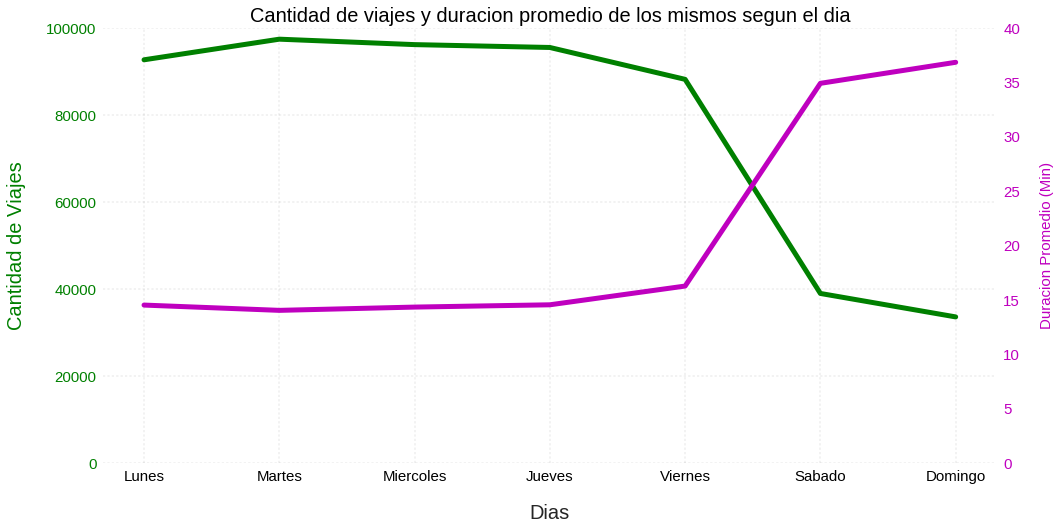

In [53]:
f = plt.figure()
ax = dif_day_trips_cant.plot(kind='line',figsize=(16,8))
ax.plot(dif_day_trips_cant,'g-',linewidth=5.0)
ax.set_title('Cantidad de viajes y duracion promedio de los mismos segun el dia', color='black',size=20.0)
ax.set_facecolor('white')
ax.set_ylabel('Cantidad de Viajes',color='g',size=20.0,labelpad=20.0);
ax.set_xlabel('Dias',size=20.0,labelpad=20.0);
ax.tick_params('y', colors='g',labelsize=15.0)
ax.tick_params('x', colors='k',labelsize=15.0)
ax.set_ylim(0,100000)
ax.set_xmargin(1.0)
ax.grid(color='k', linestyle='dotted',linewidth=0.1)
ax2 = ax.twinx()
red_patch = mpatches.Patch(color='r', label='Avg Duration(min)');blue_patch = mpatches.Patch(color='b', label='# Trips')
ax2.plot(dif_day_trips_avg,'m-',linewidth=5.0)

ax2.set_xticklabels(['-','Lunes','Martes','Miercoles','Jueves','Viernes','Sabado','Domingo'])
ax2.set_ylabel('Duracion Promedio (Min)', color='m',size=15.0,labelpad=20.0)
ax2.tick_params('y', colors='m',labelsize=15.0)
ax2.set_ylim(0,40)
ax2.set_facecolor('white')
ax2.grid(b=False)
ax.legend().set_visible(False)
plt.show()

# Viajes segun el tipo de subscripcion

In [54]:
subscription_trips = trip_meta.loc[:,['duration(min)','subscription_type']]
subscription_trips = subscription_trips.groupby('subscription_type').agg([np.mean,np.size])
subscription_trips

duration(min)          
                           mean      size
subscription_type                        
Customer              65.862689  103213.0
Subscriber             9.834148  566746.0

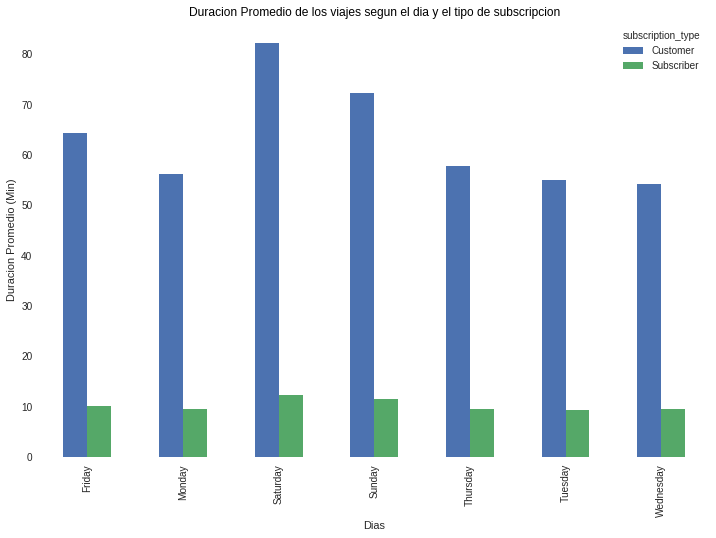

In [55]:
subscription_trips2 = trip_meta.loc[:,['duration(min)','subscription_type','start_date2']]
subscription_trips2['weekday'] = subscription_trips2['start_date2'].apply(lambda x: x.strftime("%A"))
subscription_trips2 = subscription_trips2.loc[:,['duration(min)','subscription_type','weekday']].\
                                                    groupby(['weekday','subscription_type']).agg([np.mean])
subscription_trips2 = pd.DataFrame(subscription_trips2.to_records())
subscription_trips2.columns = ['weekday','subscription_type','Avg Trip']
subscription_trips2 = pd.pivot_table(subscription_trips2,values='Avg Trip',columns='subscription_type',index='weekday')

f = plt.figure()
ax = subscription_trips2.plot.bar(figsize=(12,8))
plt.title('Duracion Promedio de los viajes segun el dia y el tipo de subscripcion', color='black')
ax.set_ylabel('Duracion Promedio (Min)');
ax.set_xlabel('Dias');
ax.set_facecolor('white')
plt.show()

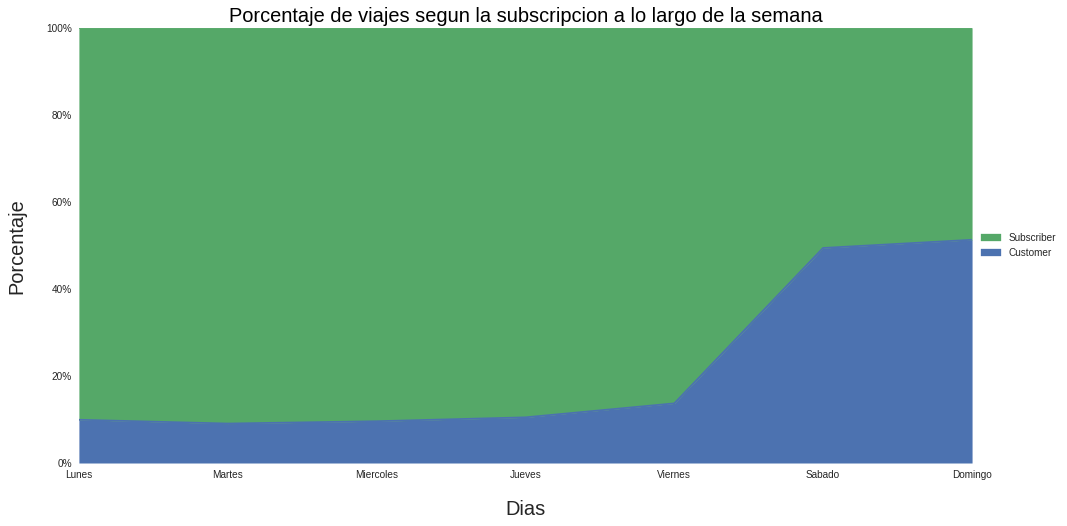

In [56]:
subscription_trips3 = trip_meta.loc[:,['duration(min)','subscription_type','start_date2']]
subscription_trips3['weekday'] = subscription_trips3['start_date2'].apply(lambda x: x.weekday())
subscription_trips3 = subscription_trips3.loc[:,['duration(min)','subscription_type','weekday']].\
                                        groupby(['weekday','subscription_type']).agg([np.size])
subscription_trips3 = pd.DataFrame(subscription_trips3.to_records())
subscription_trips3.columns = ['weekday','subscription_type','trips']
subscription_trips3 = pd.pivot_table(
                            subscription_trips3,values='trips',columns='subscription_type',index='weekday')
subscription_trips3 = subscription_trips3.divide(subscription_trips3.sum(axis=1),axis=0)

f = plt.figure()
ax = subscription_trips3.plot(kind='area', stacked=True,figsize=(16,8),ax=f.gca())
handles, labels = ax.get_legend_handles_labels()
ax.set_xticklabels(['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado','Domingo'])
ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])
ax.set_ylabel('Porcentaje',size=20.0,labelpad=20.0);
ax.set_xlabel('Dias',size=20.0,labelpad=20.0);
ax.set_title('Porcentaje de viajes segun la subscripcion a lo largo de la semana', color='black',size=20.0)
ax.set_ylim(0,1)
plt.legend(handles[::-1], labels[::-1],loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## ¿Cuáles son las estaciones más populares?

In [57]:
station_stats = pd.concat([trip_meta['start_station_name'], trip_meta['end_station_name']])

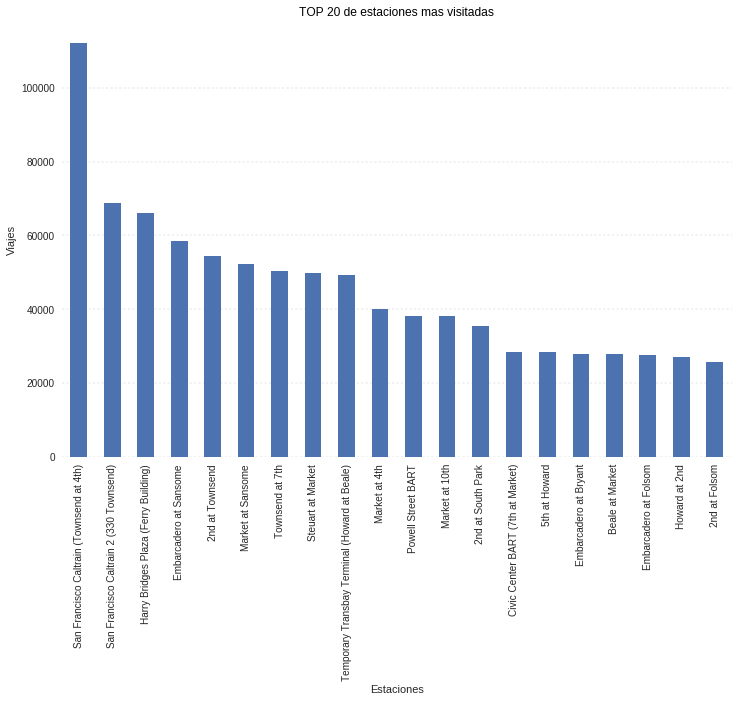

In [58]:
# TOP 20 Estaciones mas populares
f = plt.figure()
ax = station_stats.value_counts().head(20).plot(kind='bar',rot=90,figsize=(12,8));
plt.title('TOP 20 de estaciones mas visitadas', color='black')
ax.set_ylabel('Viajes');
ax.grid(color='k',axis='y' ,linestyle='dotted',linewidth=0.1)
ax.set_xlabel('Estaciones');
ax.set_facecolor('white')
plt.show()

## ¿Cuáles son las estaciones más usadas según el día?

In [59]:
popular_stations = trip_meta[['start_date','start_station_name','duration(min)']]

In [60]:
# Filtro los viajes que duran menos de 5 minutos
popular_stations = popular_stations.loc[popular_stations['duration(min)'] > 5,:]

In [61]:
popular_stations.rename(columns={'start_date':'date','start_station_name':'station'},inplace=True)

In [62]:
popular_stations['weekday'] = popular_stations.date.apply(lambda x: x.weekday())

In [63]:
popular_stations = popular_stations[['station','duration(min)','weekday']]

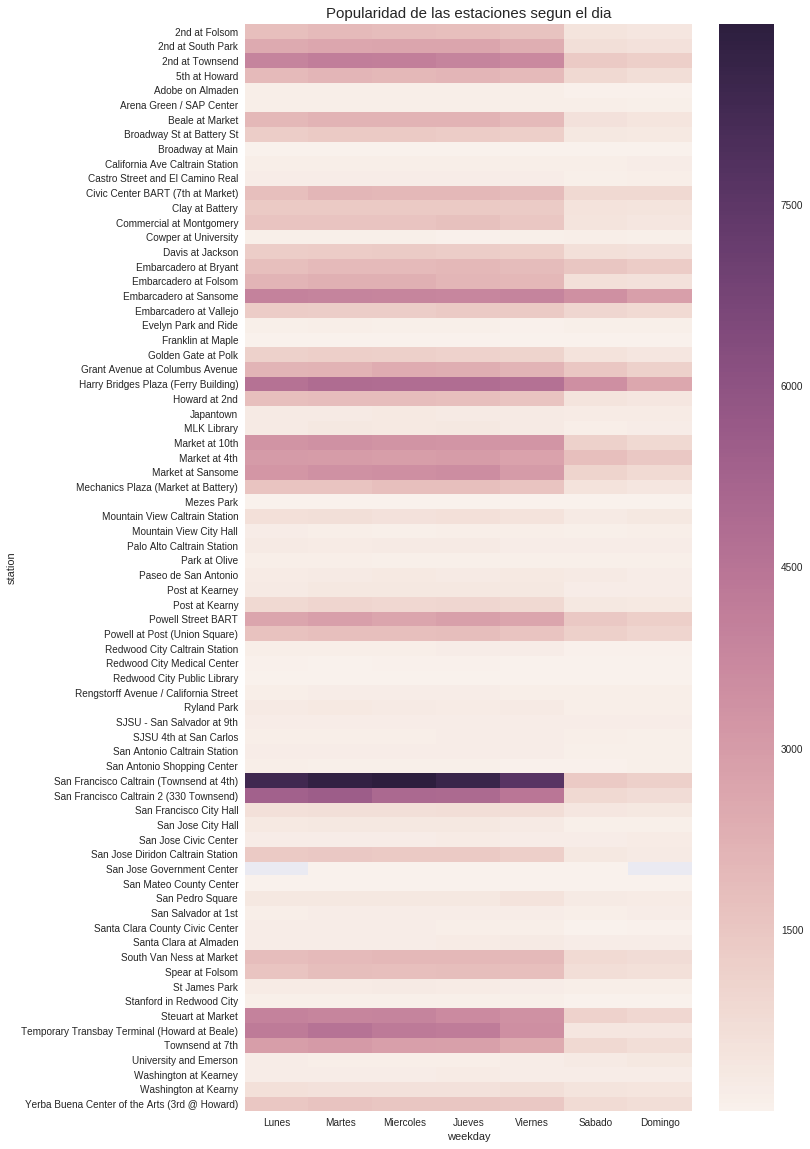

In [64]:
popular_stations = popular_stations.groupby(['station','weekday']).agg([np.size])
popular_stations = pd.DataFrame(popular_stations.to_records())
popular_stations.columns = ['station','weekday','trips']
popular_stations = pd.pivot_table(popular_stations,values='trips',columns='weekday',index='station')
fig, ax = plt.subplots(figsize=(10,20))
ax = sns.heatmap(popular_stations)
ax.set_xticklabels(['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado','Domingo'])
ax.set_title("Popularidad de las estaciones segun el dia", fontsize=15)
ax

## Se ve claramente como hay estaciones que de lunes a viernes son extremadamente populares mientras que los fines de semana decrece su uso enormemente, probablemente por su ubicación centrica y relacionada con áreas laborales.

## ¿Cuál de las estaciones nuevas fue la mas usada?

In [85]:
station_meta = pd.read_csv('data/station.csv')
station_meta['installation_date'] = pd.to_datetime(station_meta['installation_date'])

In [66]:
last_year = datetime.datetime(2014,1,1)
new_stations = station_meta.loc[station_meta.installation_date >= last_year]

In [67]:
final.rename(columns={'start_station_name':'name'},inplace=True)
new_stations = pd.merge(final,new_stations,how='inner',on='name')

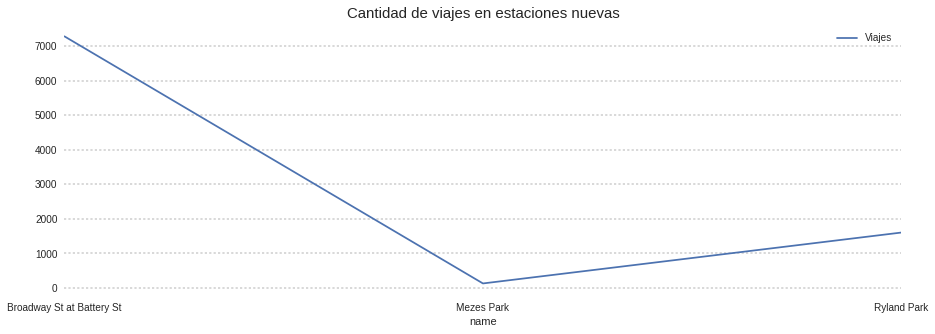

In [68]:
ax = new_stations[['name','installation_date']]\
                .groupby('name').count()\
                .rename(columns={'installation_date':'Viajes'})\
                .plot(figsize=(15,5));
ax.grid(color='k', linestyle='dotted',axis='y' ,linewidth=0.3)
ax.set_title("Cantidad de viajes en estaciones nuevas", fontsize=15)
ax.set_facecolor("white")
ax

## Broadway St at Battery St fue de las 3 estaciones más nuevas la más frecuentada.

### Aclaración: se consideró como nuevas a las estaciones cuya fecha de instalación databan a partir del 2014 (último año del set de datos)

## ¿Cuál es el promedio de docks por estación?

In [84]:
# Quiero ver cual es el promedio de docks en cada estacion
station_meta['dock_count'].mean()

17.65714285714286

## ¿Qué cantidad de docks posee la más usada de las nuevas?

In [70]:
# Ahora quiero ver que pasa en Broadway St at Battery (de las nuevas, la mas usada)
station_meta.loc[station_meta.name == 'Broadway St at Battery St']['dock_count']

67    15
Name: dock_count, dtype: int64

## Como la estación más usada de las nuevas tiene un número de docks levemente por debajo del promedio, podría ser una sugerencia útil, agregarle algunos docks más a la estación.

## ¿Cuál es la ciudad que mas usa el servicio?

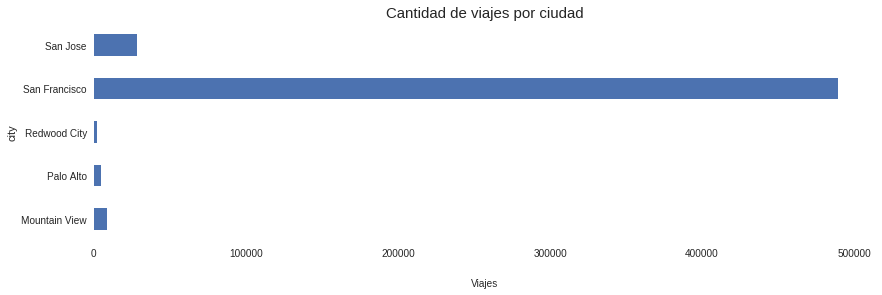

In [71]:
popular_city = pd.merge(final,station_meta,how='inner',on='name')
ax = popular_city.groupby('city').count()['id_x'].plot(kind='barh',figsize=(14,4));
ax.set_title("Cantidad de viajes por ciudad", fontsize=15)
ax.set_xlabel('Viajes',size=10.0,labelpad=20.0)
ax.set_facecolor("white")

## Por amplia diferencia San Francisco es la ciudad que más uso le da al servicio.

# -------------------------------------------------------------------------------------------------------- 

## Analisis segun fechas

In [72]:
dates_df = pd.DataFrame()
dates_df['date'] = trip_meta['start_date'].dt.date
dates_df['trips'] = dates_df.groupby('date')['date'].transform('count')
dates_df = dates_df.drop_duplicates('date')
dates_df.reset_index(drop = True, inplace = True)

In [73]:
dates_df['date'] = pd.to_datetime(dates_df['date'])
dates_df.dtypes

date     datetime64[ns]
trips             int64
dtype: object

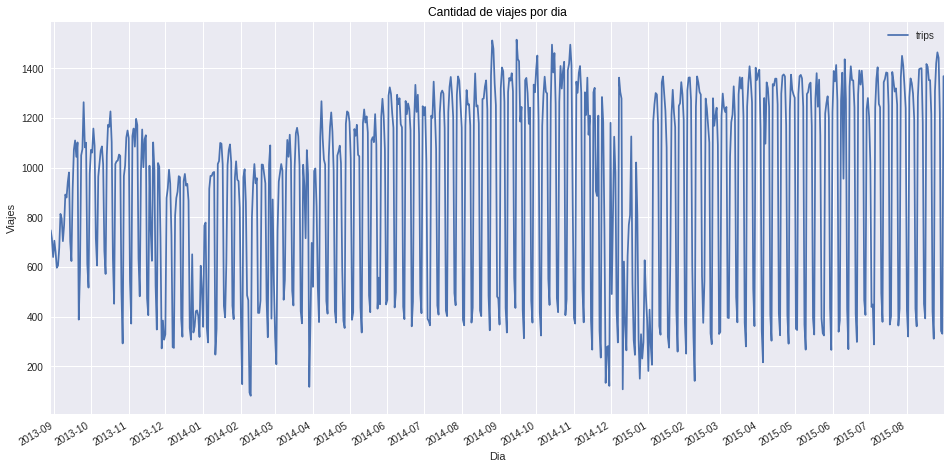

In [74]:
import matplotlib.dates as mdates
f = plt.figure()
plt.title('Cantidad de viajes por dia', color='black')
ax = (dates_df.set_index('date')).plot(kind='line', stacked=True,figsize=(16,8),ax=f.gca())
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel('Viajes');
ax.set_xlabel('Dia');
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

In [75]:
#Busco los feriados en el tiempo transcurrido
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=dates_df.date.min(), end=dates_df.date.max())

In [76]:
dates_df['holiday'] = dates_df.date.isin(holidays)

In [77]:
dates_df['weekend'] = dates_df['date'].dt.dayofweek > 4

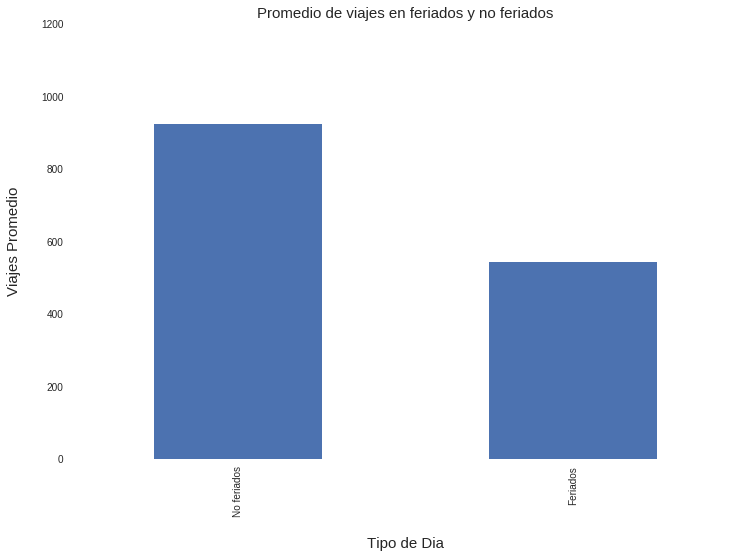

In [78]:
holidays_mean = dates_df.groupby('holiday')['trips'].mean()
ax = holidays_mean.plot.bar(figsize=(12,8))
ax.set_xticklabels(['No feriados','Feriados'])
ax.set_title("Promedio de viajes en feriados y no feriados", fontsize=15)
ax.set_ylabel('Viajes Promedio',size=15.0,labelpad=20.0)
ax.set_xlabel('Tipo de Dia',size=15.0,labelpad=20.0)
ax.set_ylim(0,1200)
ax.set_facecolor("white")

### Periodo 2014

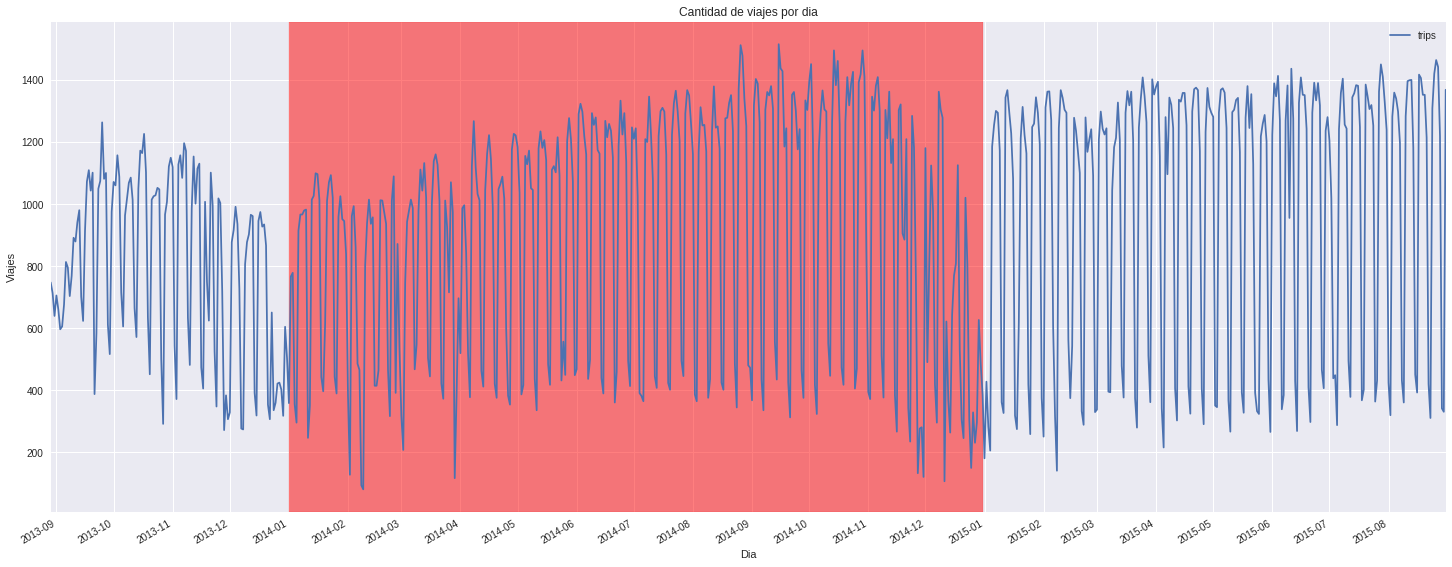

In [79]:
f = plt.figure()
plt.title('Cantidad de viajes por dia')
ax = (dates_df.loc[:,['trips','date']].set_index('date')).plot(figsize=(25,10),ax=f.gca())
ax.set_ylabel('Viajes');
ax.set_xlabel('Dia');
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.axvspan(*mdates.datestr2num(['1/1/2014', '12/31/2014']), color='red', alpha=0.5)
plt.show()

In [80]:
trips_2014 = dates_df.loc[(dates_df['date'] >= datetime.date(2014,1,1)) & (dates_df['date'] < datetime.date(2015,1,1))]
trips_2014.sort_values('date',inplace=True)

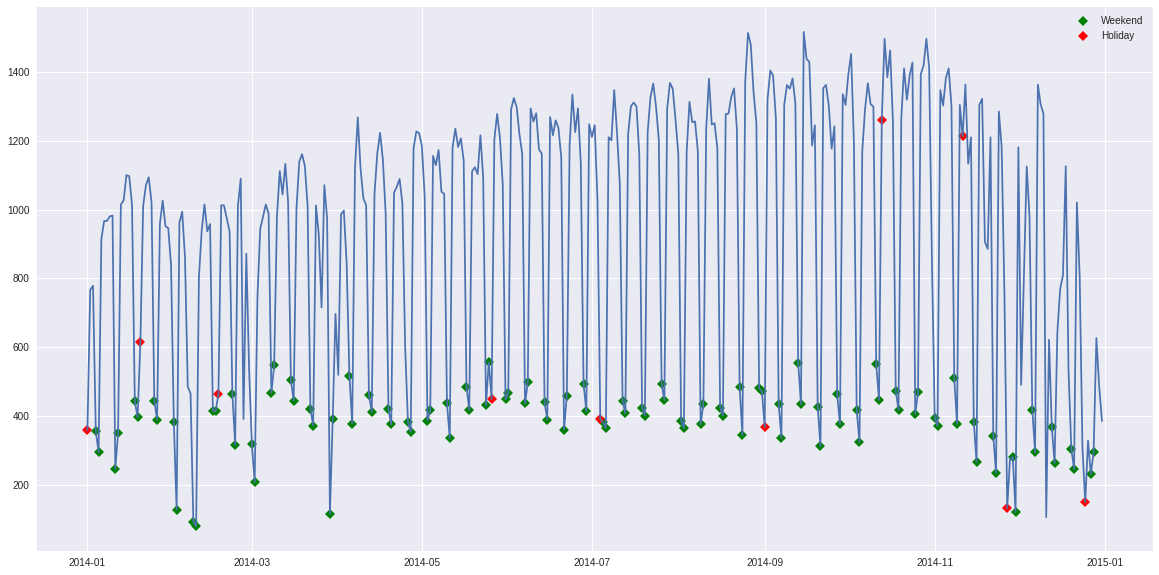

In [81]:
holidays_2014 = trips_2014.loc[trips_2014['holiday']]
weekends_2014 = trips_2014.loc[trips_2014['weekend']]
plt.figure(figsize=(20,10))
weekends_plt, = plt.plot(weekends_2014['date'],weekends_2014['trips'],'gD',label='Weekend')
holidays_plt, = plt.plot(holidays_2014['date'],holidays_2014['trips'],'rD',label='Holiday')
plt.plot(trips_2014['date'],trips_2014['trips'],'-')
plt.legend(handles=[weekends_plt,holidays_plt])
plt.show()

## ¿Qué bicicletas tienen mas tiempo recorrido?

In [82]:
bike_longer = trip_meta.loc[trip_meta.start_date2 == trip_meta.end_date2,['duration(min)','bike_id']]
bike_longer = bike_longer.loc[bike_longer['duration(min)'] > 5,:]

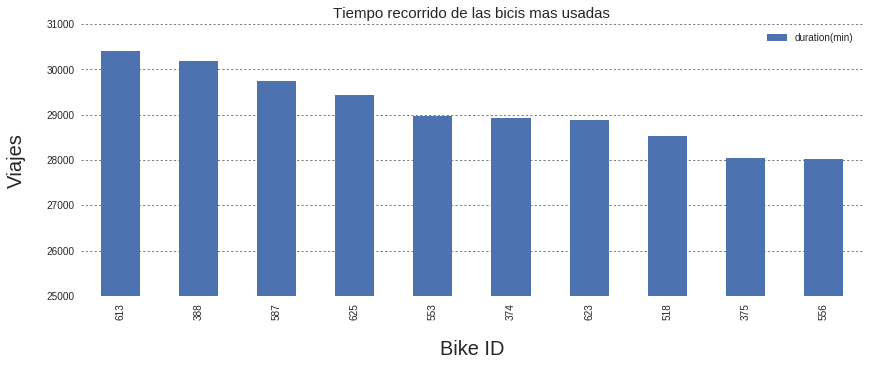

In [83]:
# TOP 10 bicicletas con mas tiempo recorrido (para posible mantenimiento)
top10 = bike_longer.groupby('bike_id').sum().sort_values('duration(min)', ascending=False).head(10)
ax = top10.plot(kind='bar',figsize=(14,5));
ax.set_title("Tiempo recorrido de las bicis mas usadas", fontsize=15)
ax.set_facecolor("white")
ax.set_ylabel('Viajes',size=20.0,labelpad=20.0)
ax.set_xlabel('Bike ID',size=20.0,labelpad=20.0)
ax.set_ylim(25000,31000)
ax.grid(color='k', linestyle='dotted',axis='y' ,linewidth=0.5)
ax

## Esta información podría ser relevante para el servicio a la hora de realizar una tarea de mantenimiento.